In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

```
pip install yacs
```


```
pip install opencv-python
```

```
conda install scipy
conda install -c conda-forge opencv 
conda install -c conda-forge json_tricks
conda install -c conda-forge pycocotools
```

OSX
```
conda install pytorch torchvision -c pytorch
```

In [2]:
from tools import init_paths
# set up paths


In [3]:
from config import cfg
from config import update_config
from core.loss import JointsMSELoss
from core.function import validate
from utils.utils import create_logger

## load config
```
python test.py --cfg experiments/mpii/hrnet/w32_256x256_adam_lr1e-3.yaml TEST.MODEL_FILE /mnt/models/HRNet/pose_mpii/pose_hrnet_w32_256x256.pth
```

In [4]:
# load config
cfg.defrost()
cfg.merge_from_file('experiments/mpii/hrnet/w32_256x256_adam_lr1e-3.yaml')
cfg.TEST.MODEL_FILE = '/mnt/models/HRNet/pose_mpii/pose_hrnet_w32_256x256.pth'    

In [5]:
cfg.MODEL

CfgNode({'NAME': 'pose_hrnet', 'INIT_WEIGHTS': True, 'PRETRAINED': 'models/pytorch/imagenet/hrnet_w32-36af842e.pth', 'NUM_JOINTS': 16, 'TAG_PER_JOINT': True, 'TARGET_TYPE': 'gaussian', 'IMAGE_SIZE': [256, 256], 'HEATMAP_SIZE': [64, 64], 'SIGMA': 2, 'EXTRA': CfgNode({'PRETRAINED_LAYERS': ['conv1', 'bn1', 'conv2', 'bn2', 'layer1', 'transition1', 'stage2', 'transition2', 'stage3', 'transition3', 'stage4'], 'FINAL_CONV_KERNEL': 1, 'STAGE2': CfgNode({'NUM_MODULES': 1, 'NUM_BRANCHES': 2, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4], 'NUM_CHANNELS': [32, 64], 'FUSE_METHOD': 'SUM'}), 'STAGE3': CfgNode({'NUM_MODULES': 4, 'NUM_BRANCHES': 3, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4, 4], 'NUM_CHANNELS': [32, 64, 128], 'FUSE_METHOD': 'SUM'}), 'STAGE4': CfgNode({'NUM_MODULES': 3, 'NUM_BRANCHES': 4, 'BLOCK': 'BASIC', 'NUM_BLOCKS': [4, 4, 4, 4], 'NUM_CHANNELS': [32, 64, 128, 256], 'FUSE_METHOD': 'SUM'})})})

In [23]:
# logger, final_output_dir, tb_log_dir = create_logger(
#         cfg, args.cfg, 'valid')

# logger.info(pprint.pformat(args))
# logger.info(cfg)

NameError: name 'args' is not defined

## load model

In [6]:
cfg.MODEL.NAME

'pose_hrnet'

In [7]:
from models.pose_hrnet import get_pose_net
model = get_pose_net(cfg,is_train=False)

In [8]:
try:
    logger.info('=> loading model from {}'.format(cfg.TEST.MODEL_FILE))
    model.load_state_dict(torch.load(cfg.TEST.MODEL_FILE), strict=False)
except:
    pass

In [10]:
import torch

USE_CUDA = True

if USE_CUDA:
    model = torch.nn.DataParallel(model, device_ids=cfg.GPUS).cuda()
else:
    model = torch.nn.DataParallel(model)
#

In [11]:
# cudnn related setting
import torch.backends.cudnn as cudnn
cudnn.benchmark = cfg.CUDNN.BENCHMARK
torch.backends.cudnn.deterministic = cfg.CUDNN.DETERMINISTIC
torch.backends.cudnn.enabled = cfg.CUDNN.ENABLED


In [12]:
# define loss function (criterion) and optimizer
criterion = JointsMSELoss(
    use_target_weight=cfg.LOSS.USE_TARGET_WEIGHT
).cuda()

In [20]:
# Data loading code
from torchvision import transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

print(cfg.DATASET.DATASET)
print(cfg.DATASET.ROOT)
print(cfg.DATASET.TEST_SET)
from dataset import mpii
valid_dataset = mpii(
# valid_dataset = eval('dataset.'+cfg.DATASET.DATASET)(
    cfg, cfg.DATASET.ROOT, cfg.DATASET.TEST_SET, False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=cfg.TEST.BATCH_SIZE_PER_GPU*len(cfg.GPUS),
    shuffle=False,
    num_workers=cfg.WORKERS,
    pin_memory=True
)

mpii
data/mpii/
valid


In [26]:
len(valid_dataset) # number of samples

2958

In [27]:
len(valid_loader) # number of workers

24

In [ ]:
# define my_validate function
def my_validate(config, val_loader, val_dataset, model, criterion, output_dir,
             tb_log_dir, writer_dict=None):
    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    num_samples = len(val_dataset)
    all_preds = np.zeros(
        (num_samples, config.MODEL.NUM_JOINTS, 3),
        dtype=np.float32
    )
    all_boxes = np.zeros((num_samples, 6))
    image_path = []
    filenames = []
    imgnums = []
    idx = 0
    with torch.no_grad():
        end = time.time()
        for i, (input, target, target_weight, meta) in enumerate(val_loader):
            # compute output
            outputs = model(input)
            if isinstance(outputs, list):
                output = outputs[-1]
            else:
                output = outputs

            if config.TEST.FLIP_TEST:
                # this part is ugly, because pytorch has not supported negative index
                # input_flipped = model(input[:, :, :, ::-1])
                input_flipped = np.flip(input.cpu().numpy(), 3).copy()
                input_flipped = torch.from_numpy(input_flipped).cuda()
                outputs_flipped = model(input_flipped)

                if isinstance(outputs_flipped, list):
                    output_flipped = outputs_flipped[-1]
                else:
                    output_flipped = outputs_flipped

                output_flipped = flip_back(output_flipped.cpu().numpy(),
                                           val_dataset.flip_pairs)
                output_flipped = torch.from_numpy(output_flipped.copy()).cuda()


                # feature is not aligned, shift flipped heatmap for higher accuracy
                if config.TEST.SHIFT_HEATMAP:
                    output_flipped[:, :, :, 1:] = \
                        output_flipped.clone()[:, :, :, 0:-1]

                output = (output + output_flipped) * 0.5

            target = target.cuda(non_blocking=True)
            target_weight = target_weight.cuda(non_blocking=True)

            loss = criterion(output, target, target_weight)

            num_images = input.size(0)
            # measure accuracy and record loss
            losses.update(loss.item(), num_images)
            _, avg_acc, cnt, pred = accuracy(output.cpu().numpy(),
                                             target.cpu().numpy())

            acc.update(avg_acc, cnt)

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            c = meta['center'].numpy()
            s = meta['scale'].numpy()
            score = meta['score'].numpy()

            preds, maxvals = get_final_preds(
                config, output.clone().cpu().numpy(), c, s)

            all_preds[idx:idx + num_images, :, 0:2] = preds[:, :, 0:2]
            all_preds[idx:idx + num_images, :, 2:3] = maxvals
            # double check this all_boxes parts
            all_boxes[idx:idx + num_images, 0:2] = c[:, 0:2]
            all_boxes[idx:idx + num_images, 2:4] = s[:, 0:2]
            all_boxes[idx:idx + num_images, 4] = np.prod(s*200, 1)
            all_boxes[idx:idx + num_images, 5] = score
            image_path.extend(meta['image'])

            idx += num_images

            if i % config.PRINT_FREQ == 0:
                msg = 'Test: [{0}/{1}]\t' \
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t' \
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t' \
                      'Accuracy {acc.val:.3f} ({acc.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time,
                          loss=losses, acc=acc)
                logger.info(msg)

                prefix = '{}_{}'.format(
                    os.path.join(output_dir, 'val'), i
                )
                save_debug_images(config, input, meta, target, pred*4, output,
                                  prefix)

        name_values, perf_indicator = val_dataset.evaluate(
            config, all_preds, output_dir, all_boxes, image_path,
            filenames, imgnums
        )

        # save all results
        np.save(output_dir+'/preds', all_preds)
        np.save(output_dir + '/boxes', all_boxes)



        model_name = config.MODEL.NAME
        if isinstance(name_values, list):
            for name_value in name_values:
                _print_name_value(name_value, model_name)
        else:
            _print_name_value(name_values, model_name)

        if writer_dict:
            writer = writer_dict['writer']
            global_steps = writer_dict['valid_global_steps']
            writer.add_scalar(
                'valid_loss',
                losses.avg,
                global_steps
            )
            writer.add_scalar(
                'valid_acc',
                acc.avg,
                global_steps
            )
            if isinstance(name_values, list):
                for name_value in name_values:
                    writer.add_scalars(
                        'valid',
                        dict(name_value),
                        global_steps
                    )
            else:
                writer.add_scalars(
                    'valid',
                    dict(name_values),
                    global_steps
                )
            writer_dict['valid_global_steps'] = global_steps + 1

    return perf_indicator


In [29]:
# evaluate on validation set
output_dir = 'output_notebook'
log_dir = 'log_notebook'
my_validate(cfg, valid_loader, valid_dataset, model, criterion,
         output_dir, log_dir)

1.2047879260994017

## analyze predictions

In [32]:
import os
from scipy.io import loadmat

pred_file = os.path.join(output_dir, 'pred.mat')
preds = loadmat(pred_file)['preds']

# see evaluate() in dataset/mpii.py

In [34]:
preds.shape

(2958, 16, 2)

[[194.67165 328.1863 ]
 [203.64525 325.1951 ]
 [197.66284 340.1511 ]
 [194.67165 319.2127 ]
 [206.63644 319.2127 ]
 [212.61884 349.1247 ]
 [212.61884 220.5032 ]
 [284.40756 232.468  ]
 [167.75087 199.56482]
 [ 79.51055  39.53577]
 [227.57483 355.1071 ]
 [182.70686 316.22153]
 [218.60123 337.1599 ]
 [194.67165 319.2127 ]
 [251.5044  337.1599 ]
 [182.70686 355.1071 ]]


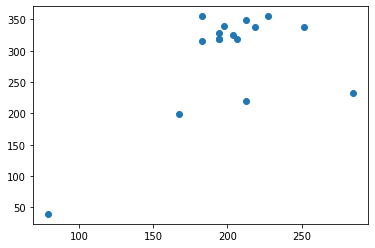

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_idx = 1200
print(preds[sample_idx])
plt.scatter(preds[sample_idx][:,0], preds[sample_idx][:,1])

In [86]:
preds[1]

array([[513.8623 , 454.6131 ],
       [214.48802, 334.17517],
       [400.30655, 440.84875],
       [341.80814, 444.28986],
       [186.95935, 337.61624],
       [102.6528 , 439.12823],
       [352.13138, 313.52866],
       [283.3097 , 196.5318 ],
       [515.5829 , 459.77472],
       [116.41713,  26.19815],
       [529.3472 , 418.48172],
       [142.22527, 358.26276],
       [314.27945, 416.76117],
       [393.42438, 454.6131 ],
       [269.54538, 430.5255 ],
       [102.6528 , 418.48172]], dtype=float32)

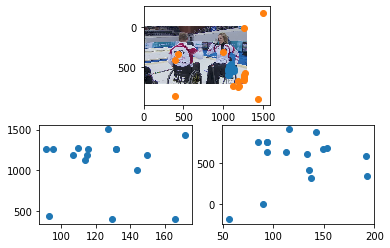

In [116]:
import cv2

sample_idx = 0
anno = valid_dataset[sample_idx][3]
# print(anno)

image_name = anno['image']
joints = anno['joints']
center = anno['center']
scale = anno['scale']

plt.subplot(211)
plt.imshow(im[:,:,::-1])
plt.scatter(joints[:,0]+center[0], joints[:,1]+center[1])
#plt.scatter(scale[0]*(joints[:,0]+1), scale[1]*(joints[:,1]+1))
plt.scatter(preds[sample_idx][:,0], preds[sample_idx][:,1])

plt.subplot(223)
plt.scatter(joints[:,0], preds[sample_idx][:,0])

plt.subplot(224)
plt.scatter(joints[:,1], preds[sample_idx][:,1])

In [118]:
preds.shape

(2958, 16, 2)

In [119]:
gt_file = os.path.join(cfg.DATASET.ROOT,
                               'annot',
                               'gt_{}.mat'.format(cfg.DATASET.TEST_SET))
gt_dict = loadmat(gt_file)
dataset_joints = gt_dict['dataset_joints']
jnt_missing = gt_dict['jnt_missing']
pos_gt_src = gt_dict['pos_gt_src']
headboxes_src = gt_dict['headboxes_src']

In [120]:
dataset_joints

array([[array(['rank'], dtype='<U4'), array(['rkne'], dtype='<U4'),
        array(['rhip'], dtype='<U4'), array(['lhip'], dtype='<U4'),
        array(['lkne'], dtype='<U4'), array(['lank'], dtype='<U4'),
        array(['pelv'], dtype='<U4'), array(['thor'], dtype='<U4'),
        array(['neck'], dtype='<U4'), array(['head'], dtype='<U4'),
        array(['rwri'], dtype='<U4'), array(['relb'], dtype='<U4'),
        array(['rsho'], dtype='<U4'), array(['lsho'], dtype='<U4'),
        array(['lelb'], dtype='<U4'), array(['lwri'], dtype='<U4')]],
      dtype=object)

In [122]:
import numpy as np
pos_pred_src = np.transpose(preds, [1, 2, 0])

In [123]:
pos_pred_src.shape

(16, 2, 2958)